In [1]:
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
%matplotlib inline

# file loader, return df['Offset', 'Size']
from file_reader import df_reader_msr
# make request, yield (Offset, Size)
from request_loader import make_request
# dispatcher
from dispatcher import DispatcherTotalHeatNoCountMiss
from dispatcher import DispatcherTotalHeatCountMiss
from dispatcher import DispatcherTotalHeatNoCountMissDecayRate
from dispatcher import DispatcherHeatNoCountMissMovingWindow
from dispatcher import DispatcherHeatNoCountMissMovingWindowDecayRate
from dispatcher import DispatcherEquivalentSystem

In [2]:
%%time
trace_df = df_reader_msr('C:/Users/28347/Documents/CDN/trace/MSR-Cambridge2/CAM-01-SRV-lvm1.csv')

Wall time: 1min 4s


In [3]:
trace_df.head()

,Offset,Size
4,542807219712,65536
5,542807285248,65536
10,542807350784,65536
11,542807416320,65536
18,542807481856,65536


In [4]:
# max file size
max(trace_df['Size'].drop_duplicates())

65536

In [5]:
min(trace_df['Size'].drop_duplicates())

512

In [6]:
%%time
FILE_NUM = len(trace_df['Offset'].value_counts())
CACHE_NUMBER = 4
WINDOW_SIZE = 1000
print('File number: ' + str(FILE_NUM))

File number: 13679648
Wall time: 14.1 s


In [7]:
%%time
total_size = trace_df.drop_duplicates(['Offset'])['Size'].sum()
total_size

Wall time: 26.4 s


In [5]:
total_size

715431715840

In [13]:
%%time
cache_size = total_size // 20
dispatcher = DispatcherEquivalentSystem(trace_df, cache_size, CACHE_NUMBER, total_size)

Wall time: 3min 8s


In [14]:
%%time
for offset, size in make_request(trace_df):
    dispatcher.handle_requests(offset, size)

Wall time: 16min 23s


In [15]:
dispatcher.big_cache.cache == dispatcher.virtual_cache.cache

True

In [16]:
len(dispatcher.big_cache_evict_record)

41426266

In [17]:
len(dispatcher.small_caches_evict_record)

41426266

In [18]:
dispatcher.big_cache_evict_record == dispatcher.small_caches_evict_record

True

In [19]:
dispatcher.small_caches[-1].max_usage

199047168

In [8]:
%%time
small_server_hit_rate_ = []
small_server_hit_number_ = []
big_server_hit_rate_ = []
big_server_hit_number_ = []

cache_size_array_ = []
for cache_size in tqdm(range(total_size // 100, total_size // 10, total_size // 100)):
    cache_size_array_.append(cache_size / total_size)
    dispatcher = DispatcherTotalHeatNoCountMissDecayRate(trace_df, cache_size, CACHE_NUMBER, 0.9999, False)
         
    for offset, size in make_request(trace_df):
        dispatcher.handle_requests(offset, size)
    small_server_hit_rate_.append([i.hit_rate() for i in dispatcher.small_caches])
    small_server_hit_number_.append(sum([i.hit_count for i in dispatcher.small_caches]))
    big_server_hit_rate_.append(dispatcher.big_cache.hit_rate())
    big_server_hit_number_.append(dispatcher.big_cache.hit_count)

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

TypeError: wrap() takes 1 positional argument but 5 were given

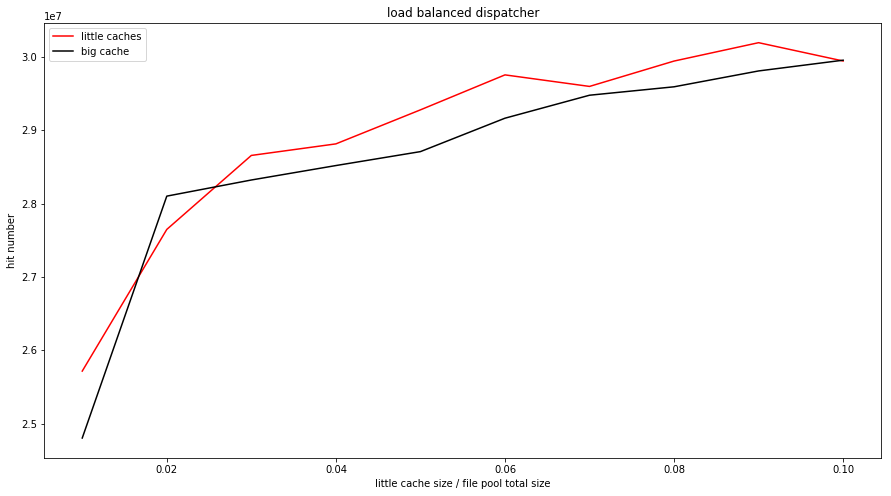

In [24]:
plt.figure(figsize=(15,8))
plt.plot(cache_size_array_, small_server_hit_number_, color='red', label='little caches')
plt.plot(cache_size_array_, big_server_hit_number_, color='black', label='big cache')
plt.xlabel("little cache size / file pool total size")
plt.ylabel("hit number")
plt.title("load balanced dispatcher")
plt.legend()

In [43]:
%%time
small_server_hit_rate_ = []
small_server_hit_number_ = []
big_server_hit_rate_ = []
big_server_hit_number_ = []

cache_size_array_ = []
for cache_size in tqdm(range(total_size // 100, total_size // 10, total_size // 100)):
    cache_size_array_.append(cache_size / total_size)
    dispatcher = DispatcherHeatNoCountMissMovingWindowDecayRate(trace_df.iloc[:100000], cache_size, CACHE_NUMBER, 10000, 0.9999, False)
    
    for offset, size in make_request(trace_df[:100000]):
        dispatcher.handle_requests(offset, size)
        
    small_server_hit_rate_.append([i.hit_rate() for i in dispatcher.small_caches])
    small_server_hit_number_.append(sum([i.hit_count for i in dispatcher.small_caches]))
    big_server_hit_rate_.append(dispatcher.big_cache.hit_rate())
    big_server_hit_number_.append(dispatcher.big_cache.hit_count)

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

Wall time: 45min 33s
